<a href="https://colab.research.google.com/github/fcoliveira-utfpr/climate_parana/blob/main/characterization_and_spatial_variability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start – Libraries
---

In [2]:
# =========================================================
# REQUIRED LIBRARIES
# =========================================================
# -------------------------
# IMPORTS
# -------------------------
!pip install geobr geopandas rasterio elevation cartopy --quiet
import warnings
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib import cm, colors
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

from geobr import read_municipality

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.2 MB/s eta 0:00:00


#Spatial distribution of annual climatic variables and climate zones in Paraná State, Brazil
---

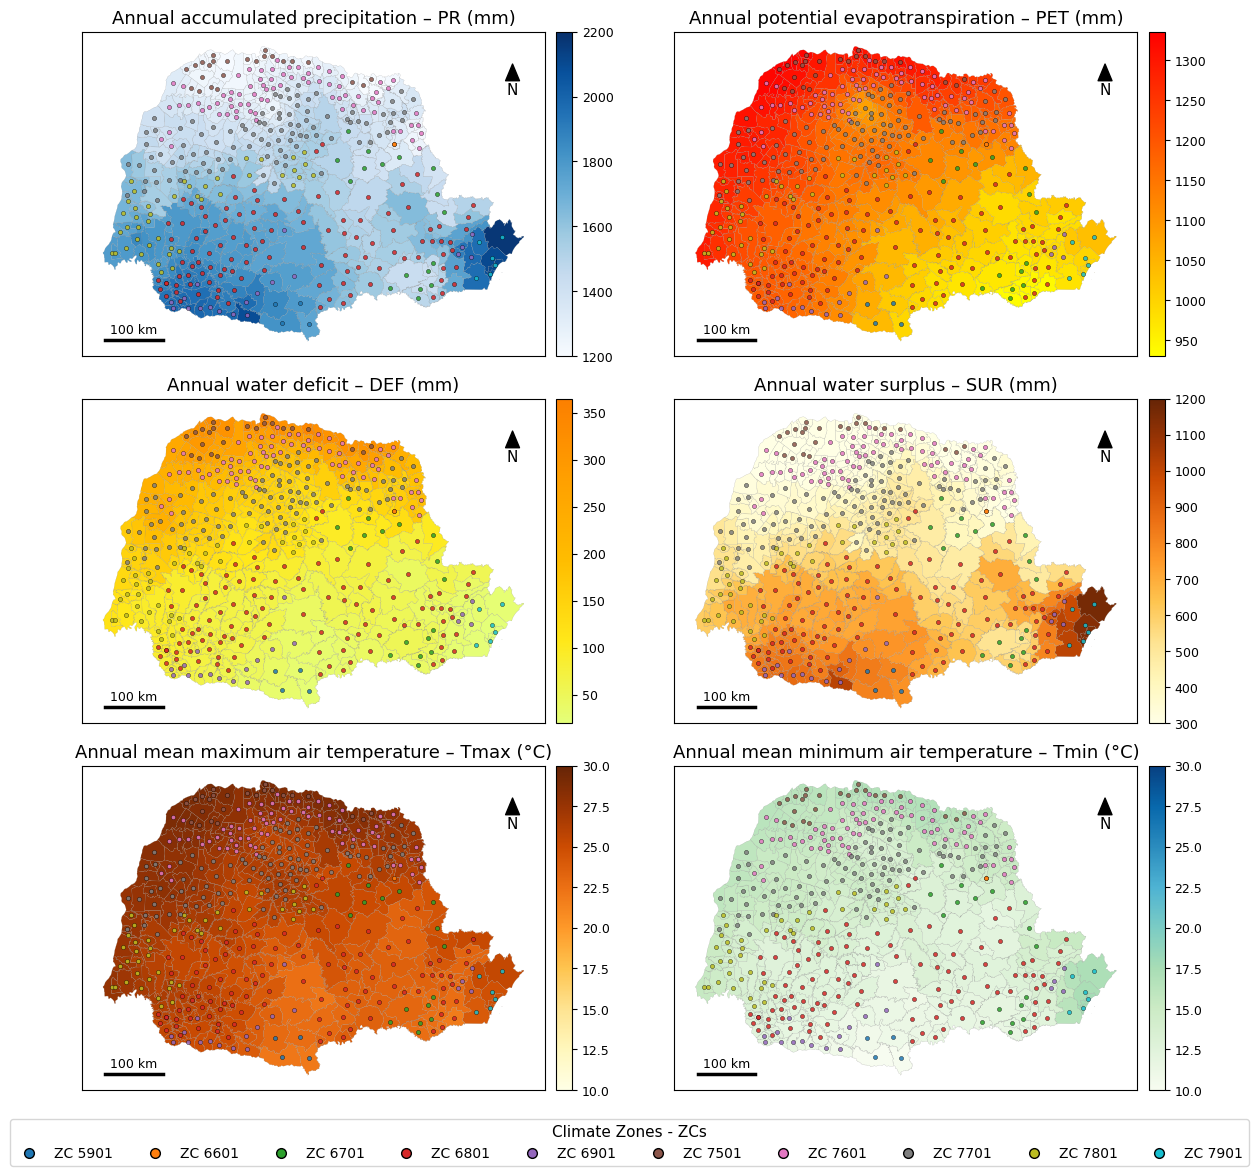

In [10]:

# =========================================================
# DATA INPUT
# =========================================================
# Load concatenated climatic dataset (continuous variables + climate zones)
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep=",")


# =========================================================
# CLIMATIC MULTIPLOT – PARANÁ STATE
# CONTINUOUS MAPS + CLIMATE ZONES
# =========================================================

# ---------------------------------------------------------
# SUPPRESS WARNINGS
# ---------------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# ---------------------------------------------------------
# AUXILIARY FUNCTIONS
# ---------------------------------------------------------
def fmt_factory(fmt):
    """
    Creates a formatter for colorbar tick labels.
    """
    return FuncFormatter(lambda x, pos: fmt % x)


def add_north_arrow(ax, x=0.93, y=0.9, size=0.08):
    """
    Adds a north arrow to the map.
    Coordinates are given in axes fraction units.
    """
    ax.annotate(
        'N',
        xy=(x, y),
        xytext=(x, y - size),
        arrowprops=dict(facecolor='black', width=3, headwidth=10),
        ha='center',
        va='center',
        fontsize=11,
        xycoords=ax.transAxes
    )


def add_scalebar(ax, length_km=100, loc=(0.05, 0.05), linewidth=2.5):
    """
    Adds an approximate scale bar (valid for Paraná latitude range).
    Conversion assumes 1° ≈ 111 km.
    """
    x0, y0 = loc
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    length_deg = length_km / 111.0  # Approximation for southern Brazil

    x_start = xlim[0] + x0 * (xlim[1] - xlim[0])
    y_start = ylim[0] + y0 * (ylim[1] - ylim[0])

    ax.plot(
        [x_start, x_start + length_deg],
        [y_start, y_start],
        color='black',
        linewidth=linewidth,
        zorder=20
    )

    ax.text(
        x_start + length_deg / 2,
        y_start + 0.01 * (ylim[1] - ylim[0]),
        f"{length_km} km",
        ha='center',
        va='bottom',
        fontsize=9
    )


# ---------------------------------------------------------
# VARIABLE SPECIFICATIONS
# ---------------------------------------------------------
VAR_SPECS = {

    # Annual accumulated precipitation
    'pr': dict(
        title="Annual accumulated precipitation – PR",
        unit="mm",
        cmap='Blues',
        vmin=1200,
        vmax=2200,
        fmt="%.0f"
    ),

    # Annual potential evapotranspiration
    'pet': dict(
        title="Annual potential evapotranspiration – PET",
        unit="mm",
        cmap='autumn_r',
        vmin=930,
        vmax=1336,
        fmt="%.0f"
    ),

    # Annual water deficit
    'def': dict(
        title="Annual water deficit – DEF",
        unit="mm",
        cmap='Wistia',
        vmin=20,
        vmax=365,
        fmt="%.0f"
    ),

    # Annual water surplus
    'ro': dict(
        title="Annual water surplus – SUR",
        unit="mm",
        cmap='YlOrBr',
        vmin=300,
        vmax=1200,
        fmt="%.0f"
    ),

    # Annual mean maximum air temperature
    'tmmx': dict(
        title="Annual mean maximum air temperature – Tmax",
        unit="°C",
        cmap='YlOrBr',
        vmin=10,
        vmax=30,
        fmt="%.1f"
    ),

    # Annual mean minimum air temperature
    'tmmn': dict(
        title="Annual mean minimum air temperature – Tmin",
        unit="°C",
        cmap='GnBu',
        vmin=10,
        vmax=30,
        fmt="%.1f"
    ),
}

vars_plot = list(VAR_SPECS.keys())


# ---------------------------------------------------------
# CLIMATE ZONE COLORS
# ---------------------------------------------------------
ZC_COLORS = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]


# ---------------------------------------------------------
# CLIMATE ZONES (SORTED ORDER)
# ---------------------------------------------------------
zonas = sorted(df['ZC'].dropna().unique(), key=lambda x: str(x))

if len(zonas) > len(ZC_COLORS):
    raise ValueError("Number of climate zones exceeds available color list.")

zona_color = {z: ZC_COLORS[i] for i, z in enumerate(zonas)}


# ---------------------------------------------------------
# PARANÁ MUNICIPALITIES (IBGE – geobr)
# ---------------------------------------------------------
mun_pr = read_municipality(code_muni="PR", year=2020)

# Standardize municipality names for merging
mun_pr['municipio'] = (
    mun_pr['name_muni']
    .str.upper()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
)


# ---------------------------------------------------------
# FIGURE LAYOUT
# ---------------------------------------------------------
n_vars = len(vars_plot)
ncols = 2
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12, 4 * nrows)
)

axes = axes.flatten()


# ---------------------------------------------------------
# MAIN LOOP – GENERATE EACH MAP
# ---------------------------------------------------------
for i, variavel in enumerate(vars_plot):

    ax = axes[i]
    spec = VAR_SPECS[variavel]

    # Filter variable
    df_var = df[df['variavel'] == variavel].copy()

    # Standardize municipality names
    df_var['municipio'] = (
        df_var['municipio']
        .str.upper()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
    )

    # Merge spatial + climatic data
    gdf_pr = mun_pr.merge(df_var, on='municipio', how='left')

    # --- CONTINUOUS MAP
    gdf_pr.plot(
        column='valor',
        cmap=spec['cmap'],
        vmin=spec['vmin'],
        vmax=spec['vmax'],
        linewidth=0.10,
        edgecolor='0.5',
        ax=ax
    )

    # --- COLORBAR
    norm = colors.Normalize(vmin=spec['vmin'], vmax=spec['vmax'])
    sm = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(spec['cmap']))
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.08,
        pad=0.02,
        shrink=1.0,
        format=fmt_factory(spec['fmt'])
    )
    cbar.ax.tick_params(labelsize=9)

    # --- COMPUTE CENTROIDS (PROJECTED CRS FOR ACCURACY)
    gdf_pr = gdf_pr.to_crs(epsg=5880)
    gdf_pr['centroid'] = gdf_pr.geometry.centroid
    gdf_pr = gdf_pr.to_crs(epsg=4674)

    # --- PLOT CLIMATE ZONE POINTS
    for z in zonas:
        sub = gdf_pr[gdf_pr['ZC'] == z]
        if sub.empty:
            continue

        ax.scatter(
            sub.centroid.x,
            sub.centroid.y,
            s=9,
            color=zona_color[z],
            edgecolor='black',
            linewidth=0.3,
            alpha=0.85,
            zorder=10
        )

    # --- CARTOGRAPHIC ELEMENTS
    add_scalebar(ax, length_km=100)
    add_north_arrow(ax)

    ax.set_title(f"{spec['title']} ({spec['unit']})", fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])


# ---------------------------------------------------------
# REMOVE EMPTY SUBPLOTS
# ---------------------------------------------------------
for j in range(i + 1, len(axes)):
    axes[j].axis('off')


# ---------------------------------------------------------
# SINGLE LEGEND FOR CLIMATE ZONES
# ---------------------------------------------------------
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='none',
        label=f'ZC {z}',
        markerfacecolor=zona_color[z],
        markeredgecolor='black',
        markersize=7
    )
    for z in zonas
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=len(zonas),
    frameon=True,
    title='Climate Zones - ZCs',
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(0.5, 0.02)
)

plt.tight_layout(rect=[0, 0.07, 1, 1])

# ---------------------------------------------------------
# EXPORT
# ---------------------------------------------------------
# plt.savefig("Figure2.png", dpi=600, bbox_inches='tight')

plt.show()
